## Tutorial - 1: Convolution - implementation and examples

Import required libraries first.

Note: We will upload the list of required libraries and provide instructions to run this notebook. 

In [86]:
import numpy as np
import scipy
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
from IPython.display import Image, display

Below is a very primitive implementation of convolution on 1d. This implements the "core" functionality of the function "scipy.signal.convolution" 

However this is a specific case where there is zero padding and the size = 'valid'.

In [87]:
def my_conv1d(a, b):
  lengtha = np.size(a)
  lengthb = np.size(b)
  c = np.zeros(lengtha + lengthb -1)
  for m in np.arange(lengtha):
    for n in np.arange(lengthb):
      c[m+n] = c[m+n] + a[m]*b[n]
  return c

Let us see an example: consider a signal with 100 sample points, which consists of ones + added gaussian random noise. Let us consider a uniform filter (initialized with 1) and then, normalized. 

We normalize our kernels just so that we end up with a similar range of values that were input to the convolution

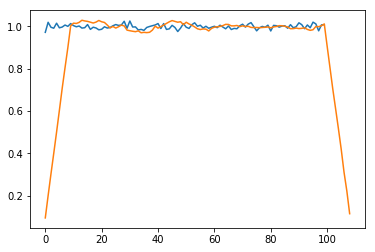

In [89]:
c = my_conv1d(np.ones(100)+0.05*np.random.randn(100), np.ones(10)/sum(np.ones(10)))
plt.plot(np.ones(100)+0.01*np.random.randn(100))
plt.plot(c)
#print(0.01*np.random.randn(100))

Now, we do a very primitive implementation of conv2d. Basically we go to each pixel and consider it's neighborhood and multiply element-wise with the kernel. This is the pixel value of the "convolved" image with the given kernel.

In [90]:
def my_conv2d(image, kernel):
  # fetch the dimensions for iteration over the pixels and weights
  kernel_sum = kernel.sum()
  i_width, i_height = image.shape[0], image.shape[1]
  k_width, k_height = kernel.shape[0], kernel.shape[1]

  # prepare the output array
  filtered = np.zeros_like(image)
    
  # Iterate over each (x, y) pixel in the image ...
  for y in range(i_height):
      for x in range(i_width):
          weighted_pixel_sum = 0

          # Iterate over each weight at (kx, ky) in the kernel defined above ...
          # We interpret the kernel weights in a way that the 'central' weight is at (0, 0);
          # so the coordinates in the kernel are:
          #
          #  [ (-1,-1),  (0,-1),  (1,-1)
          #    (-1, 0),  (0, 0),  (1, 0)
          #    (-1, 1),  (0, 1),  (1, 1)
          #
          # This way, the pixel at image[y,x] is multiplied with the kernel[0,0]; analogous,
          # image[y-1,x] is multiplied with kernel[-1,0] etc.
          # The filtered pixel is then the sum of these, so that
          #
          #   weighted_pixel_sum = image[y-1,x-1] * kernel[-1,-1] +
          #                        image[y-1,x  ] * kernel[-1, 0] +
          #                        image[y-1,x+1] * kernel[-1, 1] +
          #                        image[y,  x-1] * kernel[ 0, 1] +
          #                        image[y,  x  ] * kernel[ 0, 0] +
          #                        etc.

          for ky in range(int(-(k_height / 2)), k_height - 1):
              for kx in range(int(-(k_width / 2)), k_width - 1):
                  pixel = 0
                  pixel_y = y - ky
                  pixel_x = x - kx

                  # boundary check: all values outside the image are treated as zero.
                  # This is a definition and implementation dependent, it's not a property of the convolution itself.
                  if (pixel_y >= 0) and (pixel_y < i_height) and (pixel_x >= 0) and (pixel_x < i_width):
                      pixel = image[pixel_y, pixel_x]

                  # get the weight at the current kernel position
                  # (also un-shift the kernel coordinates into the valid range for the array.)
                  #print(kx, ky)
                  weight = kernel[int(ky + (k_height / 2)), int(kx + (k_width / 2))]

                  # weigh the pixel value and sum
                  weighted_pixel_sum += pixel * weight

          # finally, the pixel at location (x,y) is the sum of the weighed neighborhood
          filtered[y, x] = weighted_pixel_sum / kernel_sum
  return filtered

Now we import an image using the cv2 package, scale it in the range [0,1]. 

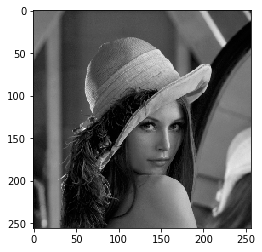

In [92]:
# load lena
image = cv2.imread('lena.jpg',cv2.IMREAD_GRAYSCALE).astype(float)/255.0
image = cv2.resize(image, (256,256))
plt.imshow(image, cmap='gray')
plt.show()

Let us use our implementation of conv2d to do uniform blurring. 

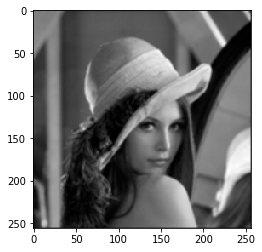

In [93]:
kernel = np.array([[1,1,1],
                  [1,1,1],
                  [1,1,1]])
#kernel = kernel/np.sum(k)
filtered_image = my_conv2d(image, kernel)
#cv2.imshow(filtered_image)
#display(Image(data=filtered_image))
plt.imshow(filtered_image, cmap='gray')
plt.show()

Now, let us see how this conv2d behaves when convolved with an indicator function.

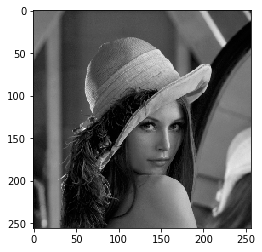

In [94]:
kernel = np.array([[0,0,0],
                  [0,1,0],
                  [0,0,0]])
filtered_image = my_conv2d(image, kernel)
#display(Image(data=filtered_image))
plt.imshow(filtered_image, cmap='gray')
plt.show()

Note: the code we wrote isn't really optimal: because it doesn't account for padding carefully. And it is (very) slow owing to its never-ending loops! 

It can be implemented efficiently by constructing a kronecker matrix using the kernel and then the kernel is basically a sparse matrix $\times$ dense matrix multiplication. Hence, it can be heavily parallelized.

Another efficient way to implment convolution is by using the "convolution theorem". By convolution theorem (as we have seen in the lecture), we know that convolution is just a multiplication operation in the Fourier domain. 

All the standard libraries in Python use such efficient implementations so, let us now use convolution operation from your favorite Python library. 

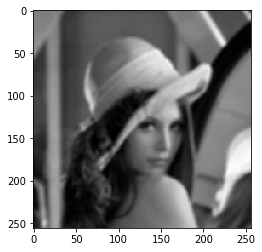

In [95]:
# 2d convolution
kernel = np.ones([5,5])
filtered_image = signal.convolve2d(
                    image, kernel, boundary='symm',mode='same')
plt.imshow(filtered_image,cmap='gray')
plt.show()

Let us look at more realistic kernels -- the Gaussian kernels

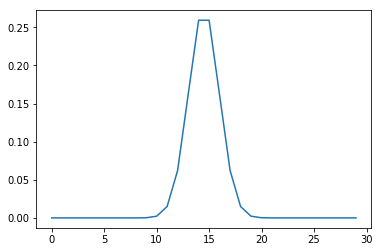

In [96]:
# 1-D Gaussian kernel
t = np.linspace(-10, 10, 30)
gauss_1d = np.exp(-0.5*t**2)
# let us normalize the kernel since we don't want to explode the values
gauss_1d /= np.sum(gauss_1d)
plt.plot(gauss_1d)

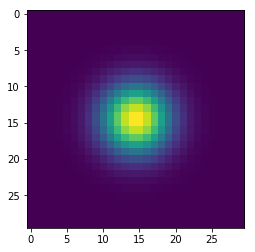

In [97]:
# 2-D Gaussian isotropic kernel
t = np.linspace(-10,10,30)
gauss_1d = np.exp(-0.1*t**2)
# we can now construct a 2D-kernel 
gauss_2d_isotropic = gauss_1d[:,np.newaxis]*gauss_1d[np.newaxis,:]
plt.imshow(gauss_2d_isotropic)

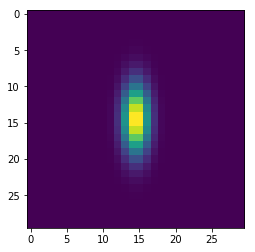

In [99]:
# 2-D Gaussian anisotropic kernel
t = np.linspace(-10,10,30)
gauss_1d_x = np.exp(-0.1*t**2)
gauss_1d_y = np.exp(-0.7*t**2)
# we can now construct a 2D-kernel 
gauss_2d_anisotropic = gauss_1d_x[:,np.newaxis]*gauss_1d_y[np.newaxis,:]
plt.imshow(gauss_2d_anisotropic)

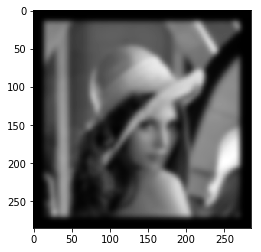

In [100]:
# Let us compare what happens when we convolve with these kernels
isotropic_filtered_image = signal.convolve2d(image, gauss_2d_isotropic)
plt.imshow(isotropic_filtered_image, cmap='gray')
plt.show()

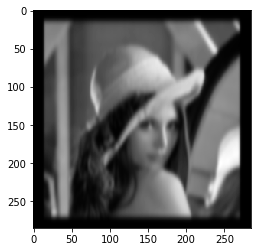

In [101]:
anisotropic_filtered_image = signal.convolve2d(image, gauss_2d_anisotropic)
plt.imshow(anisotropic_filtered_image, cmap='gray')
plt.show()

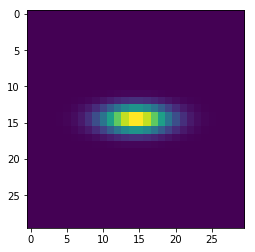

In [102]:
rotated90_anisotropic_filter = np.transpose(gauss_2d_anisotropic)
plt.imshow(rotated90_anisotropic_filter)
plt.show()

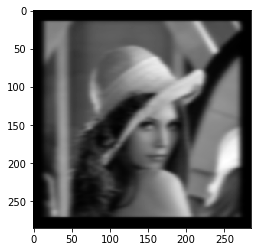

In [103]:
rotated_anisotropic_filtered_image = signal.convolve2d(image, rotated90_anisotropic_filter)
plt.imshow(rotated_anisotropic_filtered_image, cmap='gray')
plt.show()

Basic sharpening filter

In [104]:
sharpen_filter = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
print(sharpen_filter)

[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]


Let's convolve with this sharpen filter

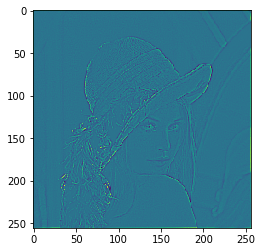

In [105]:
details_image = signal.convolve2d(image, sharpen_filter,mode='same')
plt.imshow(details_image)

Let's add this details back to the original image to increase the sharpness 

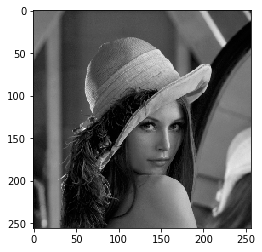

In [83]:
sharpened_image = image + details_image
sharpened_image = image - np.min(sharpened_image)
sharpened_image = image*255/np.max(sharpened_image)
plt.imshow(sharpened_image,cmap='gray')
plt.show()

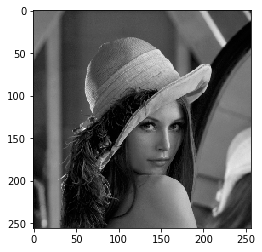

In [107]:
plt.imshow(image,cmap='gray')
plt.show()

Previously we've constructed an anisotropic Gaussian kernel by multiplying two Gaussian kernels with different $\sigma$'s but realistic blur is not exactly Gaussian, it can be random motions etc. Let us see a more general way of constructing kernels, we'll see for the case of Gaussian but they can trivially be replaced by any other function of choice.

In [108]:
def gaussian_kernel(l=5, sig=1.):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    #2D-Gaussian function in our case, but this can be any arbitrary function parametrized by x and y
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))

    return kernel / np.sum(kernel)

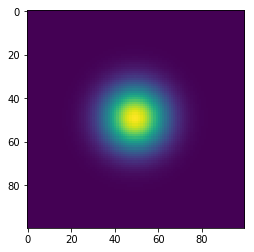

In [110]:
kernel = gaussian_kernel(100, sig = 10)
plt.imshow(kernel)
plt.show()